# From loading path to plot a image and label pair

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as pts
from Utils.DbTools import *

Using TensorFlow backend.


In [2]:
"""
Drawing Utils
"""
def draw_rects(image,bboxs,bulbs,Wsize=20,isShowBulb=True):
    colormap = [(255,0,0),(0,255,0),(0,0,255),(100,100,100),(100,100,100),(100,100,100),(100,100,100)]
    for i,bbx in enumerate(bboxs):
        cv2.putText(image, str(i), (bbx[1],bbx[2]), cv2.FONT_HERSHEY_SIMPLEX,
            1, (0, 255, 255), 1, cv2.LINE_AA)
        cv2.rectangle(image,(bbx[1],bbx[2]),(bbx[1]+bbx[3],bbx[2]+bbx[4]),
                      colormap[int(bbx[0])],Wsize)
    if isShowBulb:
        for blb in bulbs:
            cv2.rectangle(image,(blb[1],blb[2]),(blb[1]+blb[3],blb[2]+blb[4]),
                          colormap[int(blb[0])],Wsize)

In [3]:
"""
Showing Utils
"""
def show_img_label(img,bbxs,blbs,isShowBulb,Plottype=True):
    imgdraw = img.copy()
    draw_rects(imgdraw,bbxs,blbs,2,isShowBulb=isShowBulb)
    show(imgdraw,Plottype=Plottype)
    
def show(img,title="image",Plottype=True):
    img = np.array(img)
    if Plottype:
        cv2.imshow(title,img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else :
        plt.imshow(img[:,:,::-1])
        plt.show()

In [4]:
"""
Other Utils
"""
def load_labels(label_path):
    label = read_numbers(label_path).astype(np.int)
    label = label.reshape(-1,5)
    return label

In [5]:
"""
Loading image and label list
"""
img_list = read_file("./datasets/images/train.txt")
bbx_list = swap_list(img_list,(["./","./datasets/images/"],
                               ["\n",".csv"],["/py","/anno/bbox/py"]))
blb_list = swap_list(img_list,(["./","./datasets/images/"],
                               ["\n",".csv"],["/py","/anno/bulb/py"]))
img_list = swap_list(img_list,(["./","./datasets/images/"],
                               ["\n",""]))

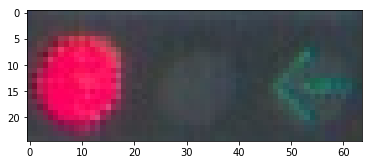

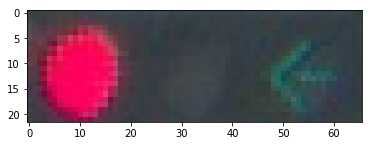

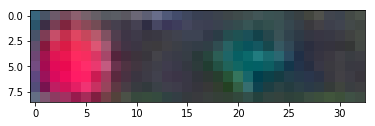

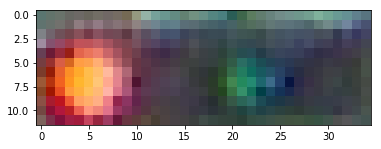

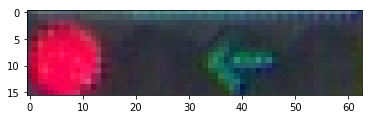

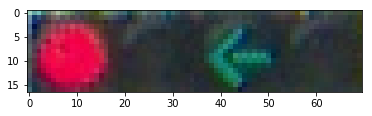

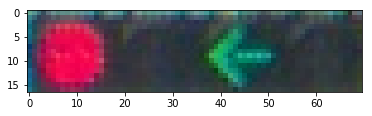

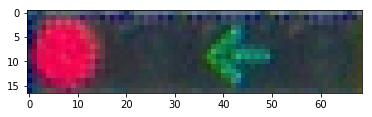

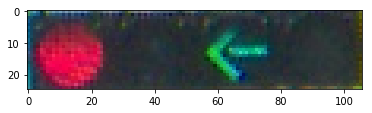

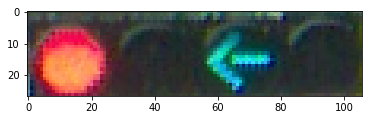

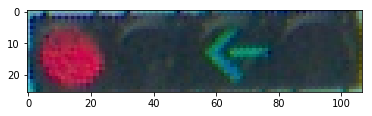

In [6]:
"""
Showing image and labels
"""
class_num = 3
for i in range(0,50):
    img = cv2.imread(os.path.abspath(img_list[i]))
    img = np.array(img)
    bbxs = load_labels(bbx_list[i])
    blbs = load_labels(blb_list[i])
    
    for b in bbxs:
        [c,x,y,w,h] = b
        if c == class_num:
            show(img[y:y+h,x:x+w],Plottype=False)
        #show_img_label(img,bbxs,blbs,isShowBulb=False,Plottype=False)

# Bellowing Part For creating TFrecord

In [7]:
from PIL import Image
import hashlib
import io,os
from object_detection.dataset_tools import tf_record_creation_util
from object_detection.utils import dataset_util
import tensorflow as tf
#from object_detection.utils import label_map_util

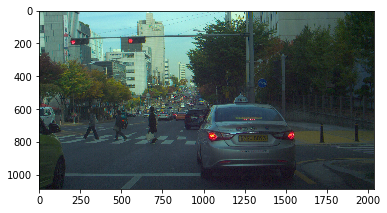

In [9]:
encoded_jpg = os.path.abspath(img_list[0])
with open(encoded_jpg, "rb") as f:
    encoded_jpg_io = io.BytesIO(f.read())
    image = Image.open(encoded_jpg_io)
#key = hashlib.sha256(encoded_jpg).hexdigest()

plt.imshow(image)
plt.show()

# with tf.gfile.GFile(encoded_jpg, 'rb') as fid:
#     encoded_jpg = fid.read()
# encoded_jpg_io = io.BytesIO(encoded_jpg)
# image = Image.open(encoded_jpg_io)
# key = hashlib.sha256(encoded_jpg).hexdigest()

In [12]:
"""
Playing Zone
"""
def create_tf_example(image_path,
                      bbx_path):
    """
    The cat_id is base on a 0-base count
    """
    # other field
    classid2name = ["Error","GreenLight","RedLight","GreenPlusLeft","RedPlusLeft"]

    # image loading
    filename = os.path.abspath(img_list[0])
    with tf.gfile.GFile(filename, 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    #key = hashlib.sha256(encoded_jpg).hexdigest()

    image_height = image.height
    image_width = image.width

    # label loading
    annotations_list = load_labels(bbx_path)

    # field setting
    xmin = []
    xmax = []
    ymin = []
    ymax = []
    is_crowd = []
    category_names = []
    category_ids = []
    area = []
    encoded_mask_png = []
    num_annotations_skipped = 0

    # label loading
    # annotations list is all the object in these image ex.(obj1,obj2,obj3,...)
    for object_annotations in annotations_list:
        (x, y, width, height) = object_annotations[1:]
        if width <= 0 or height <= 0:
          num_annotations_skipped += 1
          continue
        if x + width > image_width or y + height > image_height:
          num_annotations_skipped += 1
          continue
        #print x, y, width, height

        # appending label on field
        xmin.append(float(x) / image_width)
        xmax.append(float(x + width) / image_width)
        ymin.append(float(y) / image_height)
        ymax.append(float(y + height) / image_height)
        #is_crowd.append(object_annotations['iscrowd'])  #Needless
        category_id = int(object_annotations[0])+1
        category_ids.append(category_id)
        category_name = classid2name[category_id].encode('utf8')
        category_names.append(category_name)
        #area.append(object_annotations['area'])  #Needless
    feature_dict = {
          'image/height':
              dataset_util.int64_feature(image_height),
          'image/width':
              dataset_util.int64_feature(image_width),
          'image/filename':
              dataset_util.bytes_feature(filename.encode('utf8')),
          'image/source_id':
              dataset_util.bytes_feature(os.path.basename(filename).encode('utf8')),
          'image/encoded':
              dataset_util.bytes_feature(encoded_jpg),
          'image/format':
              dataset_util.bytes_feature('jpg'.encode('utf8')),
          'image/object/bbox/xmin':
              dataset_util.float_list_feature(xmin),
          'image/object/bbox/xmax':
              dataset_util.float_list_feature(xmax),
          'image/object/bbox/ymin':
              dataset_util.float_list_feature(ymin),
          'image/object/bbox/ymax':
              dataset_util.float_list_feature(ymax),
          'image/object/class/text':
              dataset_util.bytes_list_feature(category_names),
          'image/object/class/label':
              dataset_util.float_list_feature(category_ids),
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    print(num_annotations_skipped)
    return example

In [14]:
writer = tf.python_io.TFRecordWriter("./TL_Seoul.record")
for i in range(30):
    tf_example = create_tf_example(img_list[i], bbx_list[i])
    writer.write(tf_example.SerializeToString())
writer.close()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


NameError: name 'FLAGS' is not defined